# Predicting Heart Disease

Image

Author: Xiaohua Su

Date: May 17th, 2022

# Overview

As of 2020, heart disease is the leading cause of death in the US, with the disease claiming close to 700,000 that year. It is the leading cause of death regardless of gender and for most race/ethnicity. This disease can lead to early death in individuals, increase medical visits and a lost of productivity in our economy. As such, it is important to try to address this. My project aims to help build a predictive model for heart disease. By being able to predict whether a patient has heart disease or not, this can be used in hospital to flag doctors to discuss way to manage this disease and prevent early death and potentially slow/mitigate the disease progression.

# Business Problem

With how prevalent heart disease is in the nation, it is important for doctors to discuss with their patients about early prevention. In order to do this, doctors would need to know more about a patient’s history in order to diagnose them with having heart disease, potentially requiring blood work in addition. Getting the results from the blood work usually happens after the patient’s is already out of the doctor’s office. Calls will then be made to discuss these results and potential follow up appointments will be made. 

Our model aims to predict whether a patient, who comes into a doctor’s office/hospital, has heart disease. By being able to predict if the patient has heart disease or not, we can then flag this patient for the doctor electronically. Instead of having to waiting for a phone call for a discussion on, that may not be between the patient and doctor, conversation between the doctor and patient about managing heart disease can begin. This flagging can help start the conversation between the doctor and patient about early prevention steps that can be made and can help lead the doctor in asking certain questions for further verification and testing.

# Data

The data was taken from the [CDC's 2020 Behavorial Risk Factor Surveillance System](https://www.cdc.gov/brfss/annual_data/annual_2020.html) (BRFSS). Due to how large the data is, this data was not uploaded to the github but can be found where the data was taken underneath the data files section.

It is a survey data performed between 2020 to 2021 from the CDC to monitor people's health-behavior, chronic health conditions, and use of services to help manage their disease. The data contains information of the individual such as `race` and `gender` that we will not use to avoid these biases in our models. A new column was created as the data does not specifically have a column called heart disease but instead has two two columns called `cvdinfr4` and `cvdcrhd4` that corresponded with whether the individual was ever told/diagnose with having a heart attack and told that they had coronary heart disease. Both questions, get at the issue of heart disease.

# Imports

***The neural network modeling was performed with tensorflow. In order for it to work properly you must have at least tensorflow 2.5 and above. Please use the provided yml file to create the enviroment properly on a windows as it has tensorflow version 2.8.0 within it. Unfortunately, I do not have access to a Mac as such a Mac yml file is not provide. Not only that but there is some known issue with more recent versions of tensorflow with the M1 chips as such I highly recommend running this notebook on a windows or a cloud base service such as google colab.***

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Normalization, IntegerLookup, CategoryEncoding
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow import  keras
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras import Model

In [2]:
seed = 7
np.random.seed(seed)

In [3]:
print(tf.__version__)

2.8.0


In [4]:
heart = pd.read_csv('./Data/heart_df.csv')

In [5]:
heart

,Unnamed: 0,state,general_health,physical_health,mental_health,health_insurance,health_care_doctors,no_doc_bc_cost,last_checkup,excercise_30,...,income_level,weight_kg,height_m,difficulty_walking,smoke100_lifetime,smokeless_tobacco_products,alcohol_consumption_30,high_risk_situations,ecigaret,heart_disease
0,0,1.0,2.0,3.0,30.0,2.0,3.0,1.0,4.0,1.0,...,1.0,48.0,170.0,2.0,1.0,3.0,0.0,2.0,1.0,0.0
1,1,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,163.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0
2,2,1.0,3.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,7.0,NaN,173.0,2.0,2.0,3.0,0.0,2.0,2.0,0.0
3,3,1.0,1.0,0.0,0.0,1.0,3.0,2.0,2.0,2.0,...,NaN,NaN,NaN,2.0,2.0,3.0,0.0,2.0,2.0,0.0
4,4,1.0,2.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,NaN,57.0,168.0,2.0,2.0,3.0,0.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397142,401953,72.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,1.0,...,NaN,55.0,150.0,2.0,2.0,3.0,0.0,2.0,NaN,0.0
397143,401954,72.0,3.0,0.0,0.0,1.0,1.0,2.0,3.0,2.0,...,4.0,76.0,152.0,2.0,2.0,3.0,0.0,2.0,NaN,0.0
397144,401955,72.0,3.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,...,1.0,72.0,124.0,2.0,2.0,3.0,0.0,2.0,NaN,0.0
397145,401956,72.0,3.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,NaN,80.0,173.0,2.0,7.0,3.0,4.0,2.0,NaN,0.0


In [6]:
heart.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
heart.drop(columns = ['education_lvl', 'income_level', 'employment_status', 'rent_own', 'health_care_doctors', \
                      'no_doc_bc_cost', 'smokeless_tobacco_products', 'high_risk_situations', 'ecigaret', 'state'],\
           inplace = True)

In [8]:
heart.dtypes

general_health            float64
physical_health           float64
mental_health             float64
health_insurance          float64
last_checkup              float64
excercise_30              float64
sleep                     float64
stroke                    float64
asthma                    float64
skin_cancer               float64
other_cancer              float64
copd_type_issue           float64
arthritis_anyform         float64
depressive_disorder       float64
kidney_disease            float64
diabetes                  float64
weight_kg                 float64
height_m                  float64
difficulty_walking        float64
smoke100_lifetime         float64
alcohol_consumption_30    float64
heart_disease             float64
dtype: object

# Train-test-validation split

In [9]:
heart = heart.head(1000)

In [10]:
heart.isna().sum()

general_health              1
physical_health            32
mental_health              15
health_insurance            2
last_checkup                6
excercise_30                0
sleep                      19
stroke                      2
asthma                      2
skin_cancer                 2
other_cancer                2
copd_type_issue             5
arthritis_anyform           3
depressive_disorder         4
kidney_disease              8
diabetes                    1
weight_kg                 108
height_m                   39
difficulty_walking         39
smoke100_lifetime          38
alcohol_consumption_30     50
heart_disease               0
dtype: int64

In [11]:
# heart.fillna(0)

# Preprocessing

In [12]:
train, val, test = np.split(heart.sample(frac=1), [int(0.6*len(heart)), int(0.8*len(heart))])

In [13]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

600 training examples
200 validation examples
200 test examples


In [14]:
neg, pos = np.bincount(heart['heart_disease'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1000
    Positive: 148 (14.80% of total)



In [15]:
# Form np arrays of labels and features.
train_labels = np.array(train.pop('heart_disease'))
bool_train_labels = train_labels != 0
val_labels = np.array(val.pop('heart_disease'))
test_labels = np.array(test.pop('heart_disease'))

In [16]:
# for analysis only not actually scaling data yet
scaler = StandardScaler()
train_features = scaler.fit_transform(train)

val_features = scaler.transform(val)
test_features = scaler.transform(test)

train_features = np.clip(train, -5, 5)
val_features = np.clip(val, -5, 5)
test_features = np.clip(test, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (600,)
Validation labels shape: (200,)
Test labels shape: (200,)
Training features shape: (600, 21)
Validation features shape: (200, 21)
Test features shape: (200, 21)


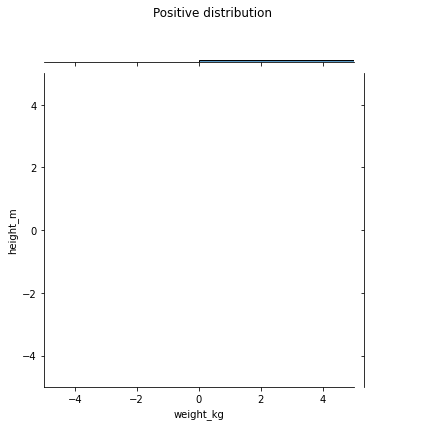

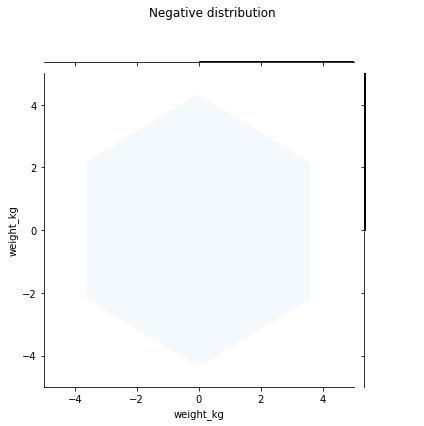

In [17]:
pos_df = pd.DataFrame(train[ bool_train_labels], columns=train.columns)
neg_df = pd.DataFrame(train[~bool_train_labels], columns=train.columns)

sns.jointplot(x=pos_df['weight_kg'], y=pos_df['height_m'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['weight_kg'], y=neg_df['weight_kg'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [18]:
target = heart.pop('heart_disease')

# Column Transformer for imputation

In [19]:
from get_features import *

In [20]:
#creating list of columns names that needs to be either scaled or OHE
continous = ['physical_health', 'mental_health', 'last_checkup' , 'excercise_30', 'sleep', 'weight_kg',
             'height_m', 'alcohol_consumption_30']

categorical = list(heart.columns.drop(continous))

In [21]:
cat_pipe = Pipeline(steps=[('cat_impute', IterativeImputer(estimator = RandomForestClassifier(),\
                                                           random_state=42, max_iter = 5))])
scale_pipe = Pipeline(steps=[('scale_impute', IterativeImputer(random_state=42))])

In [22]:
ct = ColumnTransformer(transformers=[('scale', scale_pipe, continous), ('cat', cat_pipe, categorical)]).fit(train)

In [23]:
def df_imputation_transformer(dataframe):
    dataframe= ct.transform(dataframe)
    dataframe = pd.DataFrame(dataframe, columns=get_feature_names(ct))
    dataframe.columns = [name.strip().replace("cat__",'').replace("scale__", '') for name in dataframe.columns]
    return dataframe

In [24]:
train = df_imputation_transformer(train)
val = df_imputation_transformer(val)
test = df_imputation_transformer(test)

C:\Users\xiaoh\Documents\Flatiron\neural_network_portion\get_features.py:36: UserWarning: Transformer scale_impute (type IterativeImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\xiaoh\Documents\Flatiron\neural_network_portion\get_features.py:36: UserWarning: Transformer cat_impute (type IterativeImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\xiaoh\Documents\Flatiron\neural_network_portion\get_features.py:36: UserWarning: Transformer scale_impute (type IterativeImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\xiaoh\Documents\Flatiron\neural_network_portion\get_features.py:36: UserWarning: Transformer cat_impute (type IterativeImputer) does not provide get_feature_names. Will return i

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   physical_health         600 non-null    float64
 1   mental_health           600 non-null    float64
 2   last_checkup            600 non-null    float64
 3   excercise_30            600 non-null    float64
 4   sleep                   600 non-null    float64
 5   weight_kg               600 non-null    float64
 6   height_m                600 non-null    float64
 7   alcohol_consumption_30  600 non-null    float64
 8   general_health          600 non-null    float64
 9   health_insurance        600 non-null    float64
 10  stroke                  600 non-null    float64
 11  asthma                  600 non-null    float64
 12  skin_cancer             600 non-null    float64
 13  other_cancer            600 non-null    float64
 14  copd_type_issue         600 non-null    fl

In [26]:
train.isna().sum().sum()

0

# Pipeline Building

In [27]:
train = round(train, ndigits=1)
val = round(val,ndigits=1)
test = round(test, ndigits=1)

In [28]:
# help to making input pipeline
def df_to_dataset(dataframe, shuffle=True, batch_size=200):
    df = heart.copy()
    labels = target
    df = {key: value[:,tf.newaxis] for key, value in heart.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(heart))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [29]:
batch_size = 20
train_ds = df_to_dataset(train, batch_size=batch_size)

<ipython-input-28-c3c3fb396465>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in heart.items()}


In [30]:
#confirms that it works
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of sleep:', train_features['sleep'])
print('A batch of targets:', label_batch )

Every feature: ['general_health', 'physical_health', 'mental_health', 'health_insurance', 'last_checkup', 'excercise_30', 'sleep', 'stroke', 'asthma', 'skin_cancer', 'other_cancer', 'copd_type_issue', 'arthritis_anyform', 'depressive_disorder', 'kidney_disease', 'diabetes', 'weight_kg', 'height_m', 'difficulty_walking', 'smoke100_lifetime', 'alcohol_consumption_30']
A batch of sleep: tf.Tensor(
[[8.]
 [7.]
 [8.]
 [6.]
 [8.]
 [7.]
 [5.]
 [5.]
 [6.]
 [6.]
 [6.]
 [8.]
 [8.]
 [8.]
 [6.]
 [5.]
 [8.]
 [8.]
 [6.]
 [8.]], shape=(20, 1), dtype=float64)
A batch of targets: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(20,), dtype=float64)


# Functions

In [31]:
# function that creates the layer for each column for the CONTINUOUS features
def get_normalization_layer(name,dataset):
    '''
    creates a layer for each continous feature as they each need to scaled and be their own layer
    '''
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [32]:
train_features

{'general_health': <tf.Tensor: shape=(20, 1), dtype=float64, numpy=
 array([[2.],
        [2.],
        [3.],
        [4.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [4.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [4.],
        [2.]])>,
 'physical_health': <tf.Tensor: shape=(20, 1), dtype=float64, numpy=
 array([[ 0.],
        [ 0.],
        [30.],
        [ 2.],
        [ 5.],
        [ 0.],
        [ 5.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [20.],
        [10.]])>,
 'mental_health': <tf.Tensor: shape=(20, 1), dtype=float64, numpy=
 array([[ 0.],
        [ 0.],
        [30.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 2.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],


In [33]:
testing_standarization = continous_df['sleep']
layer = get_normalization_layer('sleep', continous_df)
layer(testing_standarization)

NameError: name 'continous_df' is not defined

In [ ]:
testing_standarization = train_features['sleep']
layer = get_normalization_layer('sleep', train_ds)
layer(testing_standarization)

#### Dealing with the categorical data

In [ ]:
#creates the categorical layers for each column
def get_category_encoding_layer(name, dataset,  max_tokens=None):
    index = IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [ ]:
train_ds

In [ ]:
test_type_col = train_features['diabetes']
test_type_layer = get_category_encoding_layer(name='diabetes',
                                              dataset=train_ds)
test_type_layer(test_type_col)

In [ ]:
test_age_col = train_features['depressive_disorder']
test_age_layer = get_category_encoding_layer(name='depressive_disorder',
                                             dataset=train_ds)
test_age_layer(test_age_col)

In [ ]:
get_normalization_layer('general_health', train_ds)

# working on our actual data instead of testing out part on these functions

In [ ]:
all_inputs = []
encoded_features = []

#  Dealing with the continuous numbers
for column_name in continous:
    numeric_col = Input(shape=(1,), name=column_name)
    normalization_layer = get_normalization_layer(column_name, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [ ]:
for column_name in categorical:
    categorical_col = Input(shape=(1,), name=column_name)
    encoding_layer = get_category_encoding_layer(column_name,train_ds)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [ ]:
batch_size = 100
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
METRICS = [
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# setting the weights as the data set is heavily imbalance.

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
#uses functional keras API
all_features = layers.concatenate(encoded_features)
x = Dense(53, activation="relu")(all_features)
x = Dense(53, activation="relu")(x)
output = Dense(1, activation= 'sigmoid')(x)

model = Model(all_inputs, output)

In [ ]:
model.compile(optimizer= Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
all_features

In [ ]:
model_history = model.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weight)

# Model 2

In [ ]:
#uses functional keras API
all_features = tf.keras.layers.concatenate(encoded_features)
x2 = tf.keras.layers.Dense(53, activation="relu")(all_features)
x2 = tf.keras.layers.Dense(53, activation="relu")(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)
output2 = tf.keras.layers.Dense(1, activation= 'sigmoid')(x2)

model2 = tf.keras.Model(all_inputs, output2)

In [ ]:
all_features

In [ ]:
model2.compile(optimizer= Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
model2_history = model2.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weight)

In [ ]:
# Model 3

In [ ]:
all_features = Concatenate(encoded_features)
x3 = Dense(53, activation="relu",kernel_regularizer=regularizers.l2(0.005))(all_features)
x3 = Dropout(0.5)(x3)
x3 = Dense(20, activation="relu")(x3)
x3 = Dropout(0.5)(x3)
output3 = Dense(1, activation= 'sigmoid')(x3)

model3 = Model(all_inputs, output3)

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
model3_history = model3.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weight)

# Model 4

In [ ]:
all_features = Concatenate(encoded_features)
x4 = Dense(53, activation="tanh")(all_features)
x4 = Dense(30, activation="relu")(x4)
x4 = Dense(20, activation="tanh")(x4)
x4 = Dense(10, activation="relu")(x4)
output4 = Dense(1, activation= 'sigmoid')(x4)

model4 = Model(all_inputs, output4)

In [ ]:
model4.compile(optimizer=Adam(learning_rate=0.01),
              loss=.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
model4_history = model4.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weight)

# Model 5

In [ ]:
all_features = Concatenate(encoded_features)
x4 = Dense(53, activation="tanh")(all_features)
x4 = Dense(30, activation="relu")(x4)
x4 = Dense(20, activation="tanh")(x4)
x4 = Dense(10, activation="relu")(x4)
output4 = Dense(1, activation= 'sigmoid')(x4)

model4 = Model(all_inputs, output4)

In [ ]:
model4.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
model4_history = model4.fit(train_ds, epochs=10, validation_data=val_ds, class_weight=class_weight)

# App

Our best model was deployed in an app. The function development in the app.py file can be found in the app development notebook. In addition, the code used to make the app on streamlit can be found in the app.py. Unfortunately, due to how big the model file is (2-4 Gb), I was unable to implement my model on the streamlit website, but managed to run it locally. As such, it is not available for others to use. In my GitHub, I have provided the streamlit environment in which I created it. This app can be run locally with the streamlit environment along with running the modeling notebook in order to get the model file into your local computer.

# Next Steps

The next step for this project would be to further refine our target. This projects only looks at heart attack and Coronary Artery Disease. These two conditions are some conditions that fall under the heart disease. Heart disease encompasses other conditions such as high blood pressure, congenital heart disease etc., it's not just CAD and heart attacks as such we would have to refine the questions being asked individual.

Not only that but more time to refine our model. Due to computational limitation of my system and the computational time, I am not able to perform as much grid-searches to fine-tune the model even further. Not only that but we can refine our model on data from patients' information form and the diagnoses given by the doctor to help improve the flagging of individuals with such a condition that way their primary doctor know to discuss this with the patient.

Build a better app. The app created was for demonstrated purposes but can be made so that instead of having to fill in the information manually, it can capture the information from a picture of the history form from a patient.